In [258]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize, medial_axis
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.animation as animation
from matplotlib import rc
from mpl_toolkits import mplot3d

# Question 1 – Stereopsis
## Section C - Random Dot Stereograms

In [259]:
def salt_n_pepper(img, pad = 101, show=False):
    noise = np.random.randint(pad, size = (img.shape[0], img.shape[1]))
    img = np.where(noise == 0, 0, img)
    img = np.where(noise == (pad-1), 1, img)
    if show:
        plt.imshow(img, cmap='gray')
    return img

def get_template(rows, cols):
    x = cols
    y = rows 
    template = np.zeros((y,x))
    template = cv2.circle(template, (x//2,y//2), x//4, color=(255,255,255), thickness=-1)
    template = cv2.circle(template, (x//2-x//6,y//2-x//4), x//8, color=(255,255,255), thickness=-1)
    template = cv2.circle(template, (x//2+x//6,y//2-x//4), x//8, color=(255,255,255), thickness=-1)
    template = cv2.circle(template, (x//2-x//10,y//2-x//12), x//20, color=(0,0,0), thickness=-1)
    template = cv2.circle(template, (x//2+x//10,y//2-x//12), x//20, color=(0,0,0), thickness=-1)
    template = cv2.ellipse(template, (x//2,6*y//10), (y//8,y//24), angle=0, startAngle=0, 
                           endAngle=360, color=(0,0,0), thickness=-1)
    template = (template==255)
    return template

### 1) A plot of the binary image of the shape template you created
### 2) A plot of the left random dots image, and the right random dots image

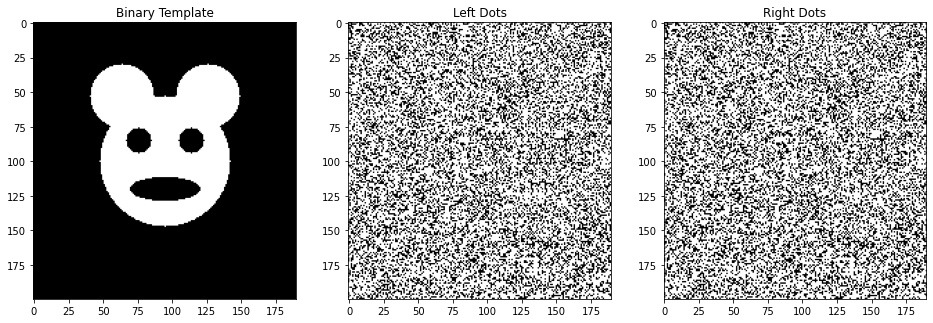

In [260]:
rows = 200
cols = 200
b = 10
template = get_template(rows, cols-b)
noise = salt_n_pepper(np.ones((rows,cols)), pad=3)
left = np.where(template==1, noise[:,b:], noise[:,:cols-b])
right = noise[:,:cols-b]

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(131)
ax1.imshow(template, cmap='gray')
ax1.set_title('Binary Template')
ax2 = fig.add_subplot(132)
ax2.imshow(left, cmap='gray')
ax2.set_title('Left Dots')
ax3 = fig.add_subplot(133)
ax3.imshow(right, cmap='gray')
_=ax3.set_title('Right Dots')

### 3 ) An animation presenting the left and right random dots images

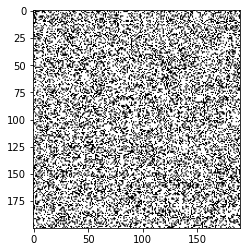

In [261]:
rc('animation', html='jshtml')

fig = plt.figure()
img = []
img.append([plt.imshow(left, cmap='gray')])
img.append([plt.imshow(right, cmap='gray')])

ani = animation.ArtistAnimation(fig, img,interval=50, blit=False, repeat=True)
ani

In [262]:
def nc(w_p, w_q):
    epsilon = 1e-5
    if w_p.shape==w_q.shape:
        w_p_normalized = (w_p - np.mean(w_p)) / (np.linalg.norm(w_p - np.mean(w_p))+epsilon)
        w_q_normalized = (w_q - np.mean(w_q)) / (np.linalg.norm(w_q - np.mean(w_q))+epsilon)
        result = np.dot(w_p_normalized.flatten(), w_q_normalized.flatten())
    else:
        result = -np.inf
    return result

def correspondence(imageL, imageR, window_size=3):
    rows, cols = imageL.shape
    corr_array = np.zeros((rows,cols,cols))
    wU = [r-window_size//2 if (r-window_size//2)>0 else 0 for r in range(rows)]
    wD = [r+window_size//2 if (r+window_size//2)<rows else rows for r in range(rows)]
    wL = [c-window_size//2 if (c-window_size//2)>0 else 0 for c in range(cols)]
    wR = [c+window_size//2 if (c+window_size//2)<cols else cols for c in range(cols)]
    #Establish correspondence for pixel p (c,r) in the left image:
    for r in range(rows):
        for c in range(cols):
            #Define a window Wp around p
            w_p = imageL[wU[r]:wD[r]+1, wL[c]:wR[c]+1]
            temp = []
            #For each pixel q along p’s epipolar line in the right image do
            for c_q in range(cols):
                #Define a window Wq around q
                w_q = imageR[wU[r]:wD[r]+1, wL[c_q]:wR[c_q]+1]
                #Compute similarity S(Wp,Wq) beween Wp and Wq
                corr_array[r,c,c_q] = nc(w_p, w_q)
    return corr_array   

In [263]:
def threeDReconstruction(f, b, imageL, imageR, window_size=5):
    rows, cols = imageL.shape
    corr = correspondence(imageL, imageR, window_size)
    zdata = [] 
    xdata = [] 
    ydata = []
    for r in range(rows):
        for c in range(cols):
            ydata.append(r)
            xdata.append(c)
            if np.argmax(corr[r,c])!=c:
                #Choose q which maximizes S(Wp,Wq) (in the case of ssd it should minimize it)
                zdata.append((b*f)/(np.argmax(corr[r,c])-c)) # Depth reconstruction – Rectified Calibrated Stereo
            else:
                zdata.append(0)
    return xdata, ydata, zdata

xdata, ydata, zdata = threeDReconstruction(1, b, left, right, window_size=5)

### 4) A plot of your 3D reconstructed shape

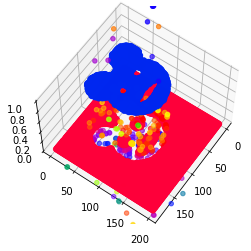

In [264]:
# Plot the 3-dimensional image
fig = plt.figure()
ax = plt.axes(projection = "3d")
ax.scatter3D(xdata,ydata,zdata, c=zdata, cmap = "prism")
ax.set_zlim(0, 1)
ax.view_init(60,35)

# Question 2 – 2D Shape Analysis
## Section A – Skeleton representation

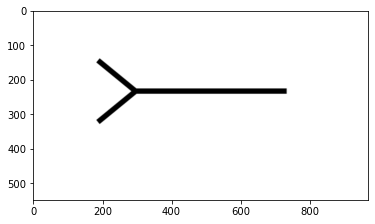

In [265]:
# Reads the "skeleton" in grayscale
img = cv2.imread('arrow.png', cv2.IMREAD_GRAYSCALE)
_=plt.imshow(img, cmap='gray')

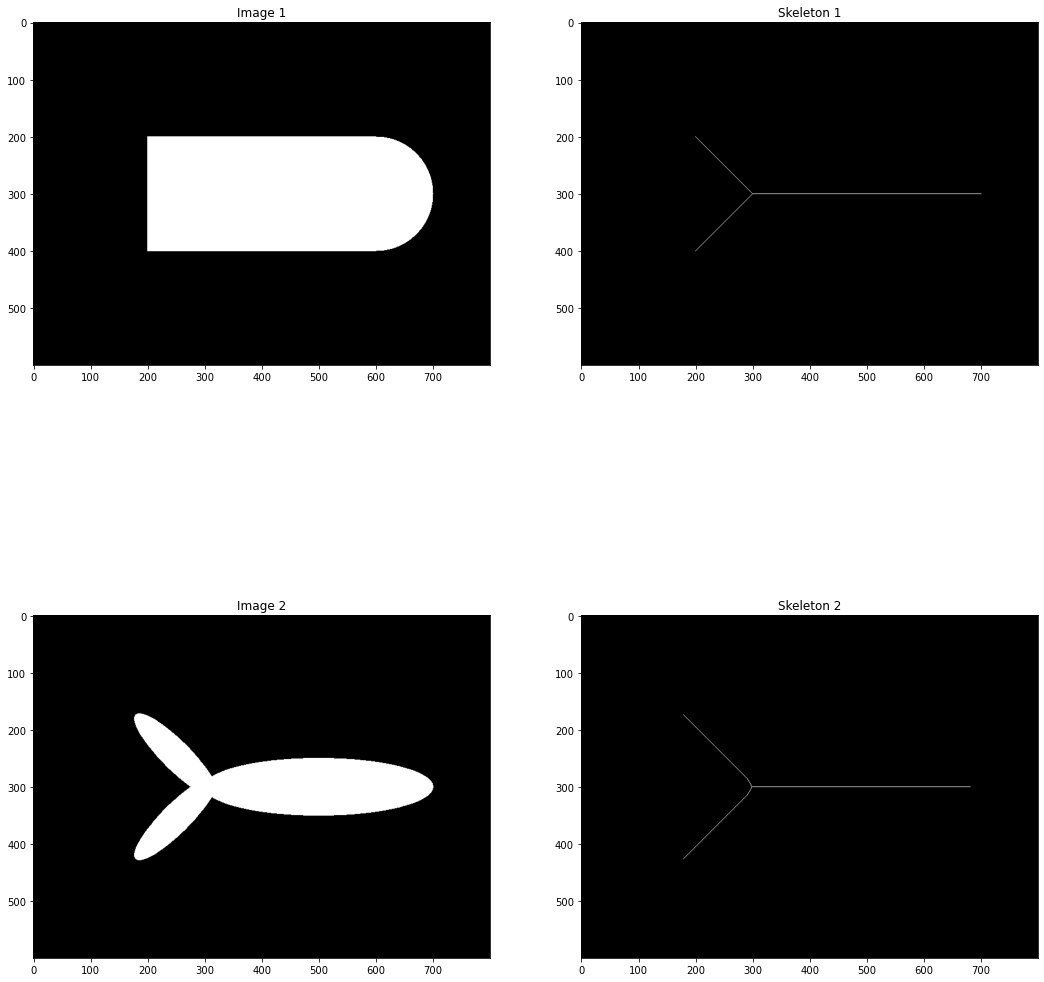

In [266]:
# Sub-section 2: Can different shapes produce the same skeleton? 
############# 
# Here you should compute the skeleton of the shape you created in sub-section 1
x1 = 200
y1 = 200
x2 = 600
y2 = 400
im1 = np.zeros((y2+y1,x2+x1))
im1 = cv2.rectangle(im1, (x1,y1), (x2,y2), color=(255,255,255), thickness=-1)
im1 = cv2.circle(im1, (x2,(y2+y1)//2), (y2-y1)//2, color=(255,255,255), thickness=-1)
im1 = (im1==255)
skel1 = medial_axis(im1)
im2 = np.zeros((y2+y1,x2+x1))
im2 = cv2.ellipse(im2, (x1+50,y1+45), ((y2-y1)//2,(y2-y1)//8), angle=45, startAngle=0, 
                 endAngle=360, color=(255,255,255), thickness=-1)
im2 = cv2.ellipse(im2, (x1+50,y2-45), ((y2-y1)//2,(y2-y1)//8), angle=-45, startAngle=0, 
                 endAngle=360, color=(255,255,255), thickness=-1)
im2 = cv2.ellipse(im2, (500,300), ((y2-y1-0),(y2-y1)//4), angle=0, startAngle=0, 
                 endAngle=360, color=(255,255,255), thickness=-1)
im2 = (im2==255)
skel2 = medial_axis(im2)

fig = plt.figure(figsize=(18,20))
ax1 = fig.add_subplot(221)
ax1.imshow(im1, cmap='gray')
ax1.set_title('Image 1')
ax2 = fig.add_subplot(222)
ax2.imshow(skel1, cmap='gray')
ax2.set_title('Skeleton 1')
ax3 = fig.add_subplot(223)
ax3.imshow(im2, cmap='gray')
ax3.set_title('Image 2')
ax4 = fig.add_subplot(224)
ax4.imshow(skel2, cmap='gray')
_=ax4.set_title('Skeleton 2')
#############

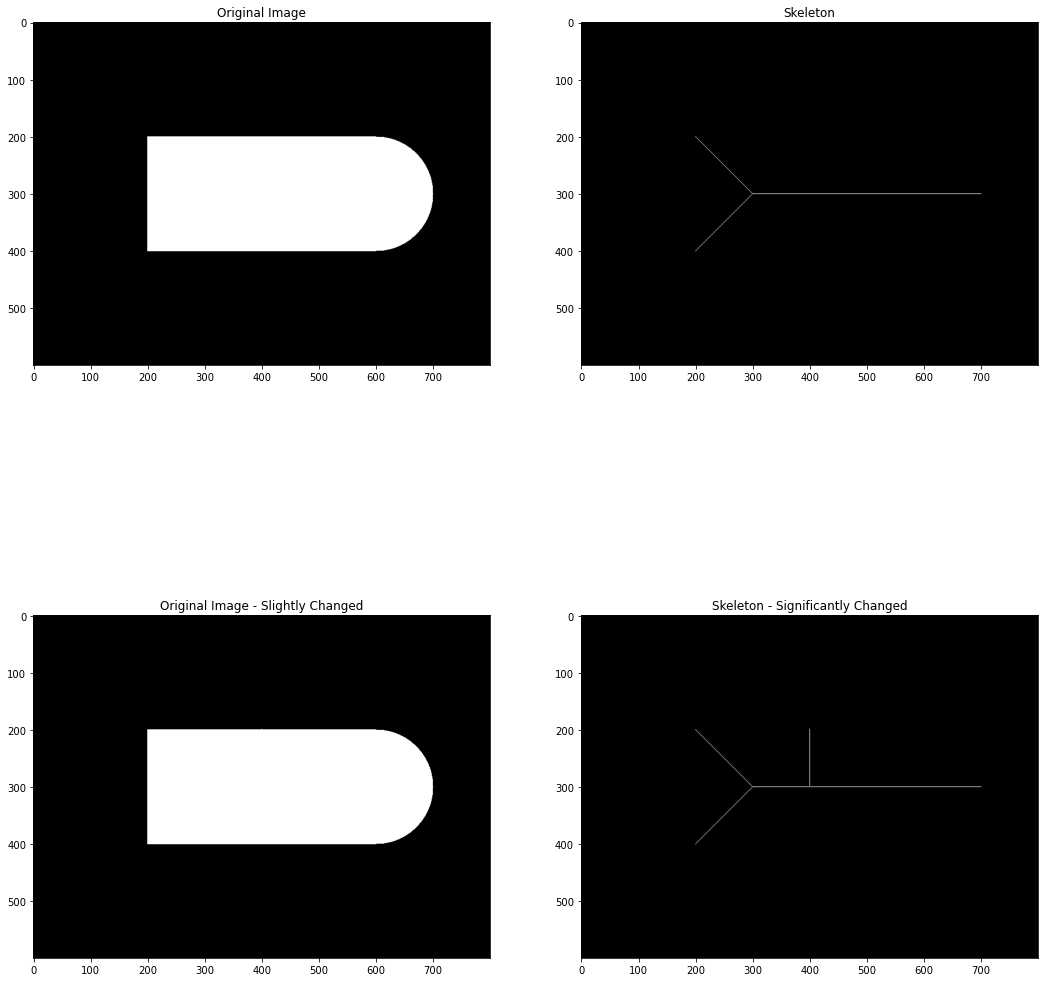

In [267]:
# Sub-section 3: Can similar shapes produce different skeletons?
#########
x1 = 200
y1 = 200
x2 = 600
y2 = 400
im1 = np.zeros((y2+y1,x2+x1))
im1 = cv2.rectangle(im1, (x1,y1), (x2,y2), color=(255,255,255), thickness=-1)
im1 = cv2.circle(im1, (x2,(y2+y1)//2), (y2-y1)//2, color=(255,255,255), thickness=-1)
im1 = (im1==255)
skel1 = medial_axis(im1)
im2 = np.zeros((y2+y1,x2+x1))
im2 = cv2.rectangle(im2, (x1,y1), (x2,y2), color=(255,255,255), thickness=-1)
im2 = cv2.circle(im2, (x2,(y2+y1)//2), (y2-y1)//2, color=(255,255,255), thickness=-1)
im2 = cv2.circle(im2, ((x1+x2)//2, y1), 1, color=(255,255,255), thickness=-1)#added very very small circle
im2 = (im2==255)
skel2 = medial_axis(im2)

fig = plt.figure(figsize=(18,20))
ax1 = fig.add_subplot(221)
ax1.imshow(im1, cmap='gray')
ax1.set_title('Original Image')
ax2 = fig.add_subplot(222)
ax2.imshow(skel1, cmap='gray')
ax2.set_title('Skeleton')
ax3 = fig.add_subplot(223)
ax3.imshow(im2, cmap='gray')
ax3.set_title('Original Image - Slightly Changed')
ax4 = fig.add_subplot(224)
ax4.imshow(skel2, cmap='gray')
_=ax4.set_title('Skeleton - Significantly Changed')
#########

# Question 3 – PCA

For this question we will be using [sklearn.datasets.load_digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) which loads the [digits dataset](https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits) (for classification problems).

This dataset has 1797 images of hand-written digits, with a total of 10 classes (10 different digits). There are approximately 180 samples for each class. Each image is 8x8 pixels in size, but is given to us as a feature vector with length 64 (which is useful, as the PCA only accepts feature vectors).


***Code to load the 'digits' dataset and split it into training and testing subsets***


```python
X_train # An array where every row is a digit image (given as a feature vector)
X_test # An array where every row is a digit image (given as a feature vector)
y_train # An array where each element y_train[i] is the digit number (label) corresponding to X_train[i] 
y_test # An array where each element y_test[i] is the digit number (label) corresponding to X_test[i]
```



In [268]:
#Function that splits the dataset into 2 subsets
def split_train_test(X,y,test_size):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
  for train_index, test_index in sss.split(X, y):
    return X[train_index], X[test_index], y[train_index], y[test_index]

#Load 'digits' dataset
digits = load_digits()
X = digits.data #All the feature vectors of the dataset, X.shape = (1797,64)
y = digits.target #All the labels of the dataset, y.shape = (1797,)

X_train, X_test, y_train, y_test = split_train_test(X,y,test_size=0.5)

In [269]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(898, 64)
(899, 64)
(898,)
(899,)


***Code to plot some examples of the training data and their labels***

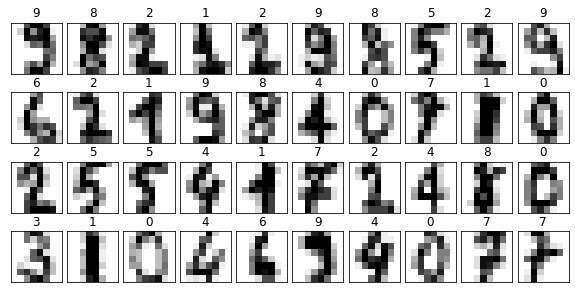

In [270]:
#Function for plotting several images of digits and their labels
def plot_digits(data,labels,img_shape):
  fig, axes = plt.subplots(4, 10, figsize=(10, 5),
                           subplot_kw={'xticks':[], 'yticks':[]},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))
  for i, ax in enumerate(axes.flat):
    ax.imshow(data[i].reshape(img_shape[0], img_shape[1]),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))
    ax.set_title('{}'.format(labels[i]))

#The images shape
img_shape = (8,8)
#Plot
plot_digits(X_train, y_train, img_shape)

***Code for computing and displaying the first 10 principal components of the training set***

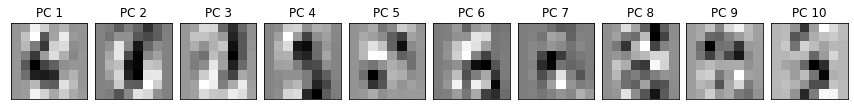

In [271]:
#Function for plotting the computed principal components
def plot_pc(pca, img_shape):
    nComponents = len(pca.components_)
    fig, axes = plt.subplots(1,nComponents, figsize=(nComponents*1.5,5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes):
        ax.imshow(pca.components_[i].reshape(img_shape[0], img_shape[1]), cmap='gray')
        ax.set_title('PC {}'.format(i+1))


nComponents = 10 #Number of components to compute
#Compute the 10 first PCs of the training set
pca = PCA(n_components=nComponents).fit(X_train)
#Plot
plot_pc(pca, img_shape)

In [272]:
components = PCA(n_components=nComponents).fit(X_train).components_

In [273]:
component1 = components[0,:].reshape(img_shape[0], img_shape[1])
component2 = components[1,:].reshape(img_shape[0], img_shape[1])
component3 = components[2,:].reshape(img_shape[0], img_shape[1])
component4 = components[3,:].reshape(img_shape[0], img_shape[1])
component5 = components[4,:].reshape(img_shape[0], img_shape[1])
component6 = components[5,:].reshape(img_shape[0], img_shape[1])
component7 = components[6,:].reshape(img_shape[0], img_shape[1])
component8 = components[7,:].reshape(img_shape[0], img_shape[1])
component9 = components[8,:].reshape(img_shape[0], img_shape[1])
component10 = components[9,:].reshape(img_shape[0], img_shape[1])

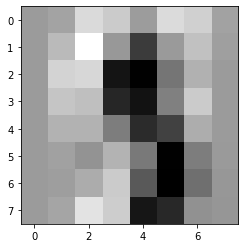

In [274]:
plt.imshow(6*component4-component6+2*component10, cmap="gray")

***Code to plot the explained variance ratio according to the number of chosen components***

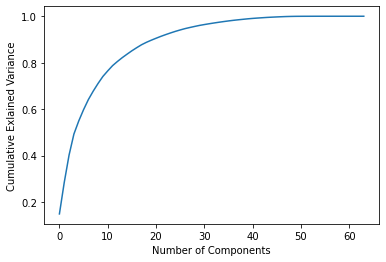

In [275]:
# Compute the pca of the training set for the total possible number of components (64)
pca = PCA().fit(X_train)

#Plot the explained variance by each number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Exlained Variance');

***Here you should write the code for the classification pipeline***

In [276]:
def stage_a(X_train, nComponents):
    pca = PCA(n_components=nComponents)
    components = pca.fit(X_train).components_
    return pca, components

def stage_b_d(X_train, pca):
    proj = pca.transform(X_train)
    return proj

def stage_c(nComponents, proj_train, y_train):
    cAPV = np.zeros((10, nComponents)) #class avg proj vec
    for i in range(0,10):
        idx_i = np.where(y_train == i)[0]
        cAPV[i,:] = np.mean(proj_train[idx_i,:], 0)
    return cAPV

#predict classes for test set:
def stage_e(proj_test, cAPV):
    y_pred = np.zeros((proj_test.shape[0]))
    for i in range(0,proj_test.shape[0]):
        pred_i = np.linalg.norm(cAPV-proj_test[i,:], axis=1)
        y_pred[i] = np.argmin(pred_i)
    return y_pred

In [277]:
### DO NOT CHANGE ### 
#This function computes the accuracy rate of your classifier
def accuracy(true_targets, predicted_targets):
    correct = np.zeros(len(true_targets))
    correct[true_targets == predicted_targets] = 1
    acc = np.mean(correct)
    return acc

### CHANGE BELOW ###
# You should create the classification pipeline as explained in HW5 pdf
def classification_pca(nComponents, X_train, X_test, y_train, y_test):
    pca, components = stage_a(X_train, nComponents)
    proj_train = stage_b_d(X_train, pca)
    cAPV = stage_c(nComponents, proj_train, y_train)
    proj_test = stage_b_d(X_test, pca)
    predicted_targets = stage_e(proj_test, cAPV) #Replace with your code for predicting a label for each sample in X_test
    # Computes the accuracy of your predictions
    acc = accuracy(y_test, predicted_targets) #DO NOT CHANGE
    return acc

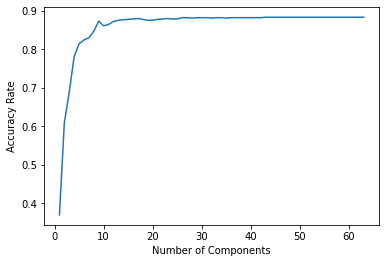

In [278]:
### DO NOT CHANGE ### 
#Computes accuracy for each number of components in the range [0,64]
acc = [classification_pca(nComponents,X_train,X_test,y_train,y_test) for nComponents in range(1,X_train.shape[1])]

#Plot the accuracy as a function of the number of components
plt.plot(list(range(1,X_train.shape[1])), acc)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy Rate');

In [279]:
acc = np.array(acc)
print(acc)
print(acc[12])

print(" Max accuracy is -> "+ str(acc.max()) +"\n Using -> " + str(acc.argmax()) + " components")

[0.36929922 0.60845384 0.68854283 0.78086763 0.81423804 0.82424917
 0.8298109  0.84649611 0.87319244 0.86095662 0.86429366 0.87208009
 0.87541713 0.87652948 0.87764182 0.87875417 0.87986652 0.87764182
 0.87541713 0.87541713 0.87764182 0.87875417 0.87986652 0.87875417
 0.87875417 0.88209121 0.88209121 0.88097887 0.88209121 0.88209121
 0.88209121 0.88097887 0.88209121 0.88209121 0.88097887 0.88209121
 0.88209121 0.88209121 0.88209121 0.88209121 0.88209121 0.88209121
 0.88320356 0.88320356 0.88320356 0.88320356 0.88320356 0.88320356
 0.88320356 0.88320356 0.88320356 0.88320356 0.88320356 0.88320356
 0.88320356 0.88320356 0.88320356 0.88320356 0.88320356 0.88320356
 0.88320356 0.88320356 0.88320356]
0.8754171301446051
 Max accuracy is -> 0.8832035595105673
 Using -> 42 components


In [280]:
from scipy.spatial import distance

def stage_e_other_distance(proj_test, cAPV):
    y_pred = np.zeros((proj_test.shape[0]))
    pred_i = np.zeros(10)
    for i in range(0,proj_test.shape[0]):
        for j in range(0,10):
            pred_i[j] = distance.minkowski(cAPV[j,:], proj_test[i,:],3)
        y_pred[i] = np.argmin(pred_i)
    return y_pred

In [281]:
def classification_pca(nComponents, X_train, X_test, y_train, y_test):
    pca, components = stage_a(X_train, nComponents)
    proj_train = stage_b_d(X_train, pca)
    cAPV = stage_c(nComponents, proj_train, y_train)
    proj_test = stage_b_d(X_test, pca)
    predicted_targets = stage_e_other_distance(proj_test, cAPV) #Replace with your code for predicting a label for each sample in X_test
    # Computes the accuracy of your predictions
    acc = accuracy(y_test, predicted_targets) #DO NOT CHANGE
    return acc

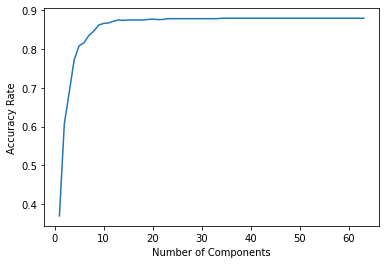

In [282]:
### DO NOT CHANGE ### 
#Computes accuracy for each number of components in the range [0,64]
acc = [classification_pca(nComponents,X_train,X_test,y_train,y_test) for nComponents in range(1,X_train.shape[1])]

#Plot the accuracy as a function of the number of components
plt.plot(list(range(1,X_train.shape[1])), acc)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy Rate');

In [283]:
acc = np.array(acc)
print(acc[15])
print(" Max accuracy is -> "+ str(acc.max()) +"\n Using -> " + str(acc.argmax()) + " components")

0.8754171301446051
 Max accuracy is -> 0.8798665183537263
 Using -> 33 components


In [284]:
print(acc[12])

0.8754171301446051


In [285]:
acc

array([0.36929922, 0.60734149, 0.68854283, 0.77196885, 0.80867631,
       0.81646274, 0.83537264, 0.84649611, 0.86206897, 0.86651835,
       0.8676307 , 0.87208009, 0.87541713, 0.87430478, 0.87541713,
       0.87541713, 0.87541713, 0.87541713, 0.87652948, 0.87764182,
       0.87652948, 0.87652948, 0.87875417, 0.87875417, 0.87875417,
       0.87875417, 0.87875417, 0.87875417, 0.87875417, 0.87875417,
       0.87875417, 0.87875417, 0.87875417, 0.87986652, 0.87986652,
       0.87986652, 0.87986652, 0.87986652, 0.87986652, 0.87986652,
       0.87986652, 0.87986652, 0.87986652, 0.87986652, 0.87986652,
       0.87986652, 0.87986652, 0.87986652, 0.87986652, 0.87986652,
       0.87986652, 0.87986652, 0.87986652, 0.87986652, 0.87986652,
       0.87986652, 0.87986652, 0.87986652, 0.87986652, 0.87986652,
       0.87986652, 0.87986652, 0.87986652])